# Fine Tuning Phase des zuvor trainierten Modells

In [1]:
import arrow
import learn2learn as l2l
import numpy as np
import os
import pickle
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.evalUtils import print_confusion_matrix

from sklearn.preprocessing import MinMaxScaler

In [2]:
%run -i ./scripts/setConfigs.py

Set configs..


## Read Models
### Meta-AE M_1

In [3]:
%run -i ./scripts/ReadSimpleAE_MetaModel.py

Load Meta Model AE..
/home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200319_firstMetaModel.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


### LogReg Meta

In [4]:
%run -i ./scripts/ReadLogReg_Meta.py

Load trained LogReg..
LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


## Load & Prepare Data

In [5]:
data_fn = os.path.join(data_path, 'simulation_data_y_2020_2021_reduced.h5')
df_data_train = pd.read_hdf(data_fn, key='df')
print('Shape of X_train data: {}'.format(df_data_train.shape))

Shape of X_train data: (105216, 17)


In [6]:
data_fn = os.path.join(data_path, 'anomalous_data_y_2022_reduced.h5')
df_data_anormal = pd.read_hdf(data_fn, key='df')
print('Shape of X_test data: {}'.format(df_data_anormal.shape))

Shape of X_test data: (35040, 18)


In [7]:
s_labels = df_data_anormal['label']
df_data_anormal.drop('label', axis=1, inplace=True)
print('Shape of X_test data: {}'.format(df_data_anormal.shape))

Shape of X_test data: (35040, 17)


In [8]:
data_fn = os.path.join(data_path, 'drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_drifted = pd.read_hdf(data_fn, key='df')
print('Shape of X_drifted data: {}'.format(df_data_drifted.shape))

Shape of X_drifted data: (35040, 18)


In [9]:
s_drift_labels_x_drifted = df_data_drifted['drift_labels']
df_data_drifted.drop('drift_labels', axis=1, inplace=True)
print('Shape of X_drifted data: {}'.format(df_data_drifted.shape))

Shape of X_drifted data: (35040, 17)


In [10]:
data_fn = os.path.join(data_path, 'anomalous_drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_drifted_ano = pd.read_hdf(data_fn, key='df')
print('Shape of X_drifted,ano data: {}'.format(df_data_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 19)


In [11]:
s_drifted_ano_drift_labels = df_data_drifted_ano['drift_labels']
s_drifted_ano_ano_labels = df_data_drifted_ano['anomaly_labels']

In [12]:
df_data_drifted_ano.drop(['drift_labels', 'anomaly_labels'], axis=1, inplace=True)
print('Shape of X_drifted,ano data: {}'.format(df_data_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 17)


In [13]:
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_train)
scaled_train = scaler_train.transform(df_data_train.to_numpy())
scaled_anormal = scaler_train.transform(df_data_anormal.to_numpy())
scaled_drifted = scaler_train.transform(df_data_drifted.to_numpy())
scaled_drifted_ano = scaler_train.transform(df_data_drifted_ano.to_numpy())

Scale data..


In [14]:
# build tensor from numpy
anormal_torch_tensor = torch.from_numpy(scaled_anormal).type(torch.FloatTensor)
anormal_drifted_torch_tensor = torch.from_numpy(scaled_drifted_ano).type(torch.FloatTensor)
drifted_torch_tensor_X = torch.from_numpy(scaled_drifted).type(torch.FloatTensor)

# Fine Tuning Phase

## Prepare Datasets

In [15]:
# build tensor from numpy
print(drifted_torch_tensor_X is None)
drifted_torch_tensor_y = torch.from_numpy(s_drift_labels_x_drifted.to_numpy().reshape(len(s_drift_labels_x_drifted),1)).type(torch.FloatTensor)

False


In [16]:
# build pytorch dataset from tensor
drifted_dataset = TensorDataset(drifted_torch_tensor_X, drifted_torch_tensor_y)

## Save Weights of Model before fine-tuning!

In [17]:
weights_meta_model = {
    'encoder_l0': meta_model.encoder[0].weight.detach().numpy().T,
    'encoder_l1': meta_model.encoder[2].weight.detach().numpy().T,
    'decoder_l0': meta_model.decoder[0].weight.detach().numpy(),
    'decoder_l1': meta_model.decoder[2].weight.detach().numpy()
}

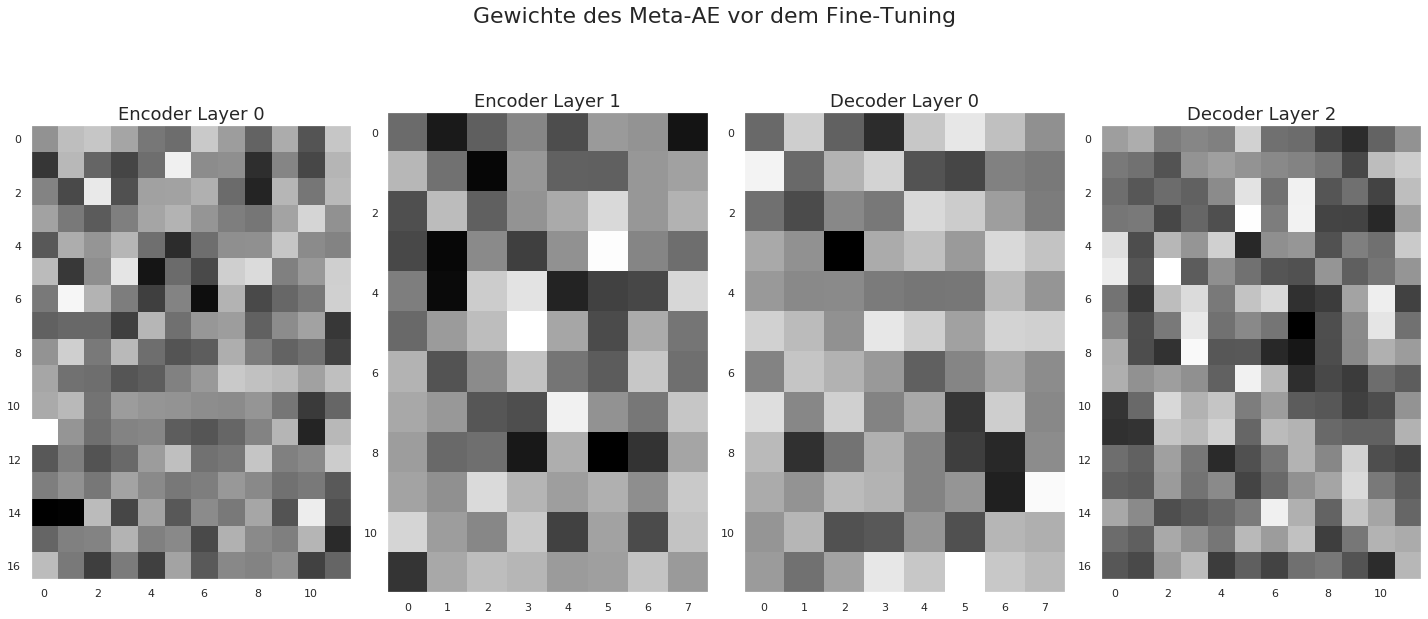

In [18]:
fig, ax = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(20, 10)

ax[0].imshow(weights_meta_model['encoder_l0'], cmap="gray")
ax[0].grid(False)
ax[0].set_title('Encoder Layer 0', fontsize=18)

ax[1].imshow(weights_meta_model['encoder_l1'], cmap="gray")
ax[1].grid(False)
ax[1].set_title('Encoder Layer 1', fontsize=18)

ax[2].imshow(weights_meta_model['decoder_l0'], cmap="gray")
ax[2].grid(False)
ax[2].set_title('Decoder Layer 0', fontsize=18)

ax[3].imshow(weights_meta_model['decoder_l1'], cmap="gray")
ax[3].grid(False)
ax[3].set_title('Decoder Layer 2', fontsize=18)
fig.suptitle('Gewichte des Meta-AE vor dem Fine-Tuning', fontsize=22)
plt.tight_layout()

save = False
if save:
    fn = os.path.join(fig_path, 'weights_meta_model_before_fine_tuning.pdf')
    fig.savefig(fn, bbox_inches='tight', pad_inches=0)

## Do fine tuning!

In [19]:
from MetaLearner.FilteredDataset import FilteredDataset
from tqdm import tqdm

In [20]:
def sample_fine_tune_data(fine_tune_data, k_shots_fine_tune, fine_tune_class):
    """
    Sample k samples from n classes and set in class variable.
    :param fine_tune_data: Data from which the samples should be drawn.
    :param k_shots_fine_tune: Number of samples to draw.
    :param fine_tune_class: List or Integer to determine which classes should be sampled.
    :return: Fine Tune Dataloader with selected Class
    """
    if not isinstance(fine_tune_data, torch.utils.data.TensorDataset):
        raise Exception('Fine Tune Data is not a pd.DataFrame!')

    # select classes
    if fine_tune_class is not None:
        dataset = FilteredDataset(fine_tune_data, fine_tune_class)
    else:
        dataset = fine_tune_data

    # select k samples
    sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=k_shots_fine_tune)
    fine_tune_DataLoader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1, sampler=sampler)
    
    return fine_tune_DataLoader

In [21]:
def set_optimizer_for_fine_tune(meta_model, optimizer='Adam', lr=1e-3):
    """
    Set PyTorch Optimizer for fine tuning phase.
    :param optimizer: String, even Adam or SGD
    :param lr: Learning Rate for Optimizer
    :return: The PyTorch optimizer object.
    """
    if optimizer == 'Adam' or optimizer == 'adam':
        optimizer = torch.optim.Adam(meta_model.parameters(), lr=lr)
    elif optimizer == 'SGD' or optimizer == 'sgd':
        optimizer = torch.optim.SGD(meta_model.parameters(), lr=lr)
    else:
        raise NotImplementedError
        
    return optimizer

In [22]:
num_iterations = 1000
loss_fine_tune = []
k_shot_fine_tune = 5

In [23]:
data_loader = sample_fine_tune_data(drifted_dataset, k_shot_fine_tune, [1,2,3])
optimizer = set_optimizer_for_fine_tune(meta_model)

### Draw k Samples

In [24]:
X = []
drift_label = []

for j , (x,y) in enumerate(data_loader):
    X.append(x)
    drift_label.append(y)

In [25]:
debug_save = []

In [26]:
meta_model.train()

# do k gradient steps for n times!
for _ in range(num_iterations):
    # do k gradient steps on the data for each of k samples
    inner_loss = 0.0
    for j, x in enumerate(X):

        x = torch.autograd.Variable(x)
        optimizer.zero_grad()

        pred = meta_model(x)
        loss = mse_loss(pred, x)
        loss_fine_tune.append(loss.item())

        inner_loss += loss.item()
        avg_inner_loss = inner_loss / k_shot_fine_tune

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        if j == 0:
            debug_save.append(loss.item())

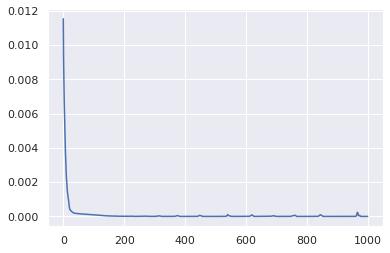

In [27]:
plt.plot(debug_save)

In [28]:
weights_meta_model_after_fine_tuning = {
    'encoder_l0': meta_model.encoder[0].weight.detach().numpy().T,
    'encoder_l1': meta_model.encoder[2].weight.detach().numpy().T,
    'decoder_l0': meta_model.decoder[0].weight.detach().numpy(),
    'decoder_l1': meta_model.decoder[2].weight.detach().numpy()
}

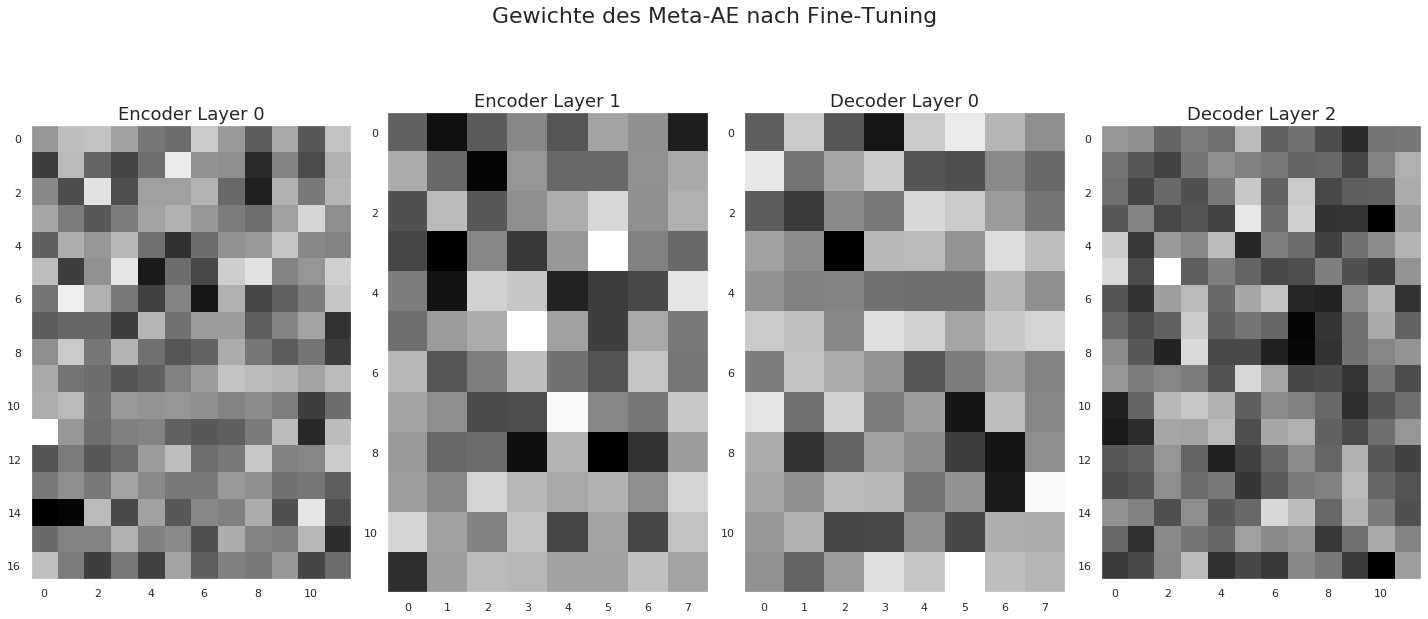

In [29]:
fig, ax = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(20, 10)

ax[0].imshow(weights_meta_model_after_fine_tuning['encoder_l0'], cmap="gray")
ax[0].grid(False)
ax[0].set_title('Encoder Layer 0', fontsize=18)

ax[1].imshow(weights_meta_model_after_fine_tuning['encoder_l1'], cmap="gray")
ax[1].grid(False)
ax[1].set_title('Encoder Layer 1', fontsize=18)

ax[2].imshow(weights_meta_model_after_fine_tuning['decoder_l0'], cmap="gray")
ax[2].grid(False)
ax[2].set_title('Decoder Layer 0', fontsize=18)

ax[3].imshow(weights_meta_model_after_fine_tuning['decoder_l1'], cmap="gray")
ax[3].grid(False)
ax[3].set_title('Decoder Layer 2', fontsize=18)
fig.suptitle('Gewichte des Meta-AE nach Fine-Tuning', fontsize=22)
plt.tight_layout()

save = False
if save:
    fn = os.path.join(fig_path, 'weights_meta_model_after_fine_tuning.pdf')
    fig.savefig(fn, bbox_inches='tight', pad_inches=0)

In [30]:
weight_diff = {
    'diff_encoder_l0': weights_meta_model['encoder_l0'] - weights_meta_model_after_fine_tuning['encoder_l0'],
    'diff_encoder_l1': weights_meta_model['encoder_l1'] - weights_meta_model_after_fine_tuning['encoder_l1'],
    'diff_decoder_l0': weights_meta_model['decoder_l0'] - weights_meta_model_after_fine_tuning['decoder_l0'],
    'diff_decoder_l1': weights_meta_model['decoder_l1'] - weights_meta_model_after_fine_tuning['decoder_l1'],
}

## Evaluate fine-tuned Model

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
from utils.evalUtils import calc_cm_metrics
from utils.evalUtils import print_confusion_matrix

In [32]:
tuned_model = meta_model

In [33]:
losses_drifted_tuned = []
for val in drifted_torch_tensor_X:
    loss = tuned_model.calc_reconstruction_error(val)
    losses_drifted_tuned.append(loss.item())
    
s_losses_drifted_tuned = pd.Series(losses_drifted_tuned)

In [34]:
X_drifted_tuned = s_losses_drifted_tuned.to_numpy()
X_drifted_tuned = X_drifted_tuned.reshape(-1, 1)
y_drifted_tuned = np.zeros(len(X_drifted_tuned))

In [35]:
predictions_X_drifted_tuned = []
for val in X_drifted_tuned:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_drifted_tuned.append(pred[0])

In [36]:
cm_tuned = confusion_matrix(y_drifted_tuned, predictions_X_drifted_tuned)
tn_tuned, fp_tuned, fn_tuned, tp_tuned  = confusion_matrix(y_drifted_tuned, predictions_X_drifted_tuned).ravel()

In [37]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp_tuned, tn_tuned, fp_tuned, fn_tuned)
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Specifity: {:.4f}'.format(specifity))
print('Sensitivity: {:.4f}'.format(sensitivity))
print('F1-Score: {:.4f}'.format(f1_score))

Accuracy: 90.5137
Precision: 0.0000
Specifity: 100.0000
Sensitivity: 0.0000
F1-Score: 0.0000


Text(0.5, 0.98, 'Confusion Matrix X_drifted')

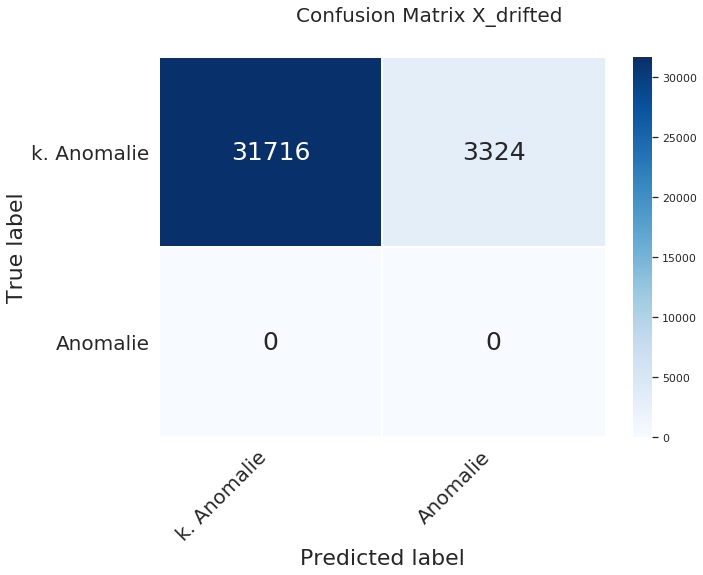

In [38]:
fig = print_confusion_matrix(cm_tuned, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted', fontsize=20)

In [39]:
losses_anormal_tuned = []
for val in anormal_torch_tensor:
    loss = tuned_model.calc_reconstruction_error(val)
    losses_anormal_tuned.append(loss.item())
    
s_losses_anormal_tuned = pd.Series(losses_anormal_tuned)

In [40]:
X_anormal_tuned = s_losses_anormal_tuned.to_numpy()
X_anormal_tuned = X_anormal_tuned.reshape(-1, 1)
y_anormal_tuned = [1 if x > 0 else 0 for x in s_labels]

In [41]:
predictions_X_anormal_tuned = []
for val in X_anormal_tuned:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_anormal_tuned.append(pred[0])

In [42]:
cm_ano_tuned = confusion_matrix(y_anormal_tuned, predictions_X_anormal_tuned)
print(cm_ano_tuned)
tn_tuned, fp_tuned, fn_tuned, tp_tuned  = confusion_matrix(y_anormal_tuned, predictions_X_anormal_tuned).ravel()

[[32543     0]
 [  159  2338]]


In [43]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp_tuned, tn_tuned, fp_tuned, fn_tuned)
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Specifity: {:.4f}'.format(specifity))
print('Sensitivity: {:.4f}'.format(sensitivity))
print('F1-Score: {:.4f}'.format(f1_score))

Accuracy: 99.5462
Precision: 100.0000
Specifity: 93.2972
Sensitivity: 93.6324
F1-Score: 96.7115


Text(0.5, 0.98, 'Confusion Matrix X_test')

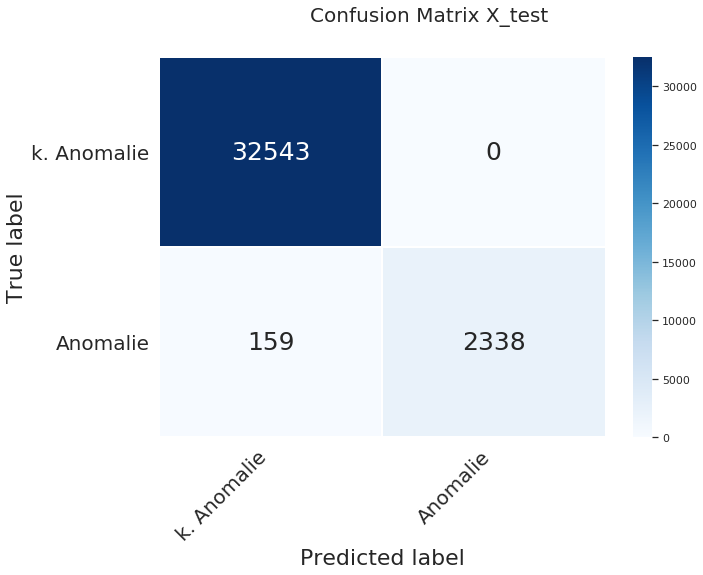

In [44]:
fig = print_confusion_matrix(cm_ano_tuned, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_test', fontsize=20)

In [45]:
losses_drifted_anormal_tuned = []
for val in anormal_drifted_torch_tensor:
    loss = tuned_model.calc_reconstruction_error(val)
    losses_drifted_anormal_tuned.append(loss.item())
    
s_losses_drifted_anormal_tuned = pd.Series(losses_drifted_anormal_tuned)

In [46]:
X_anormal_drifted_tuned = s_losses_drifted_anormal_tuned.to_numpy()
X_anormal_drifted_tuned = X_anormal_drifted_tuned.reshape(-1, 1)
y_anormal_drifted_tuned = [1 if x > 0 else 0 for x in s_drifted_ano_ano_labels]

In [47]:
predictions_X_drifted_anormal_tuned = []
for val in X_anormal_drifted_tuned:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_drifted_anormal_tuned.append(pred[0])

In [48]:
cm_drifted_ano_tuned = confusion_matrix(y_anormal_drifted_tuned, predictions_X_drifted_anormal_tuned)
print(cm_drifted_ano_tuned)
tn_tuned, fp_tuned, fn_tuned, tp_tuned  = confusion_matrix(y_anormal_drifted_tuned, predictions_X_drifted_anormal_tuned).ravel()

[[29230  3313]
 [  168  2329]]


In [49]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp_tuned, tn_tuned, fp_tuned, fn_tuned)
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Specifity: {:.4f}'.format(specifity))
print('Sensitivity: {:.4f}'.format(sensitivity))
print('F1-Score: {:.4f}'.format(f1_score))

Accuracy: 90.0656
Precision: 41.2797
Specifity: 92.6202
Sensitivity: 93.2719
F1-Score: 57.2306


Text(0.5, 0.98, 'Confusion Matrix X_drifted,anormal')

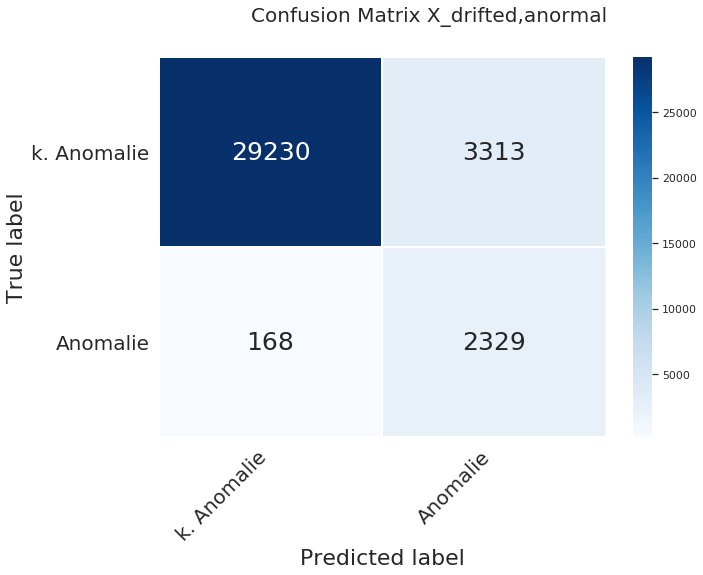

In [53]:
fig = print_confusion_matrix(cm_drifted_ano_tuned, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted,anormal', fontsize=20)

## Save fine-tuned Model

In [51]:
type(tuned_model)

models.SimpleAutoEncoder.SimpleAutoEncoder

In [52]:
model_fn = '{}_FineTunedMetaModel.pt'.format(arrow.now().format('YYYYMMDD'))
print('Model Name: {}'.format(model_fn))
torch.save(tuned_model.state_dict(), os.path.join(model_bib_path, model_fn))

Model Name: 20200331_FineTunedMetaModel.pt
